<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/04_02_AE_fashion_mnist_conv_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실습 4-2 :  Convolutional Auto Encoder** 


## **Import Module**

In [0]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, utils

tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## **DataSet**

### Options

In [0]:
#options
#select dataset : fashion_mnist or mnist
fashion_mnist_on = True     #Fashion MNIST 
#fashion_mnist_on = False   # MNIST

#select noise on/off : on 시 denoising  
#noise_on = True            # DAE
noise_on = False            # AE


### Load

In [0]:
if fashion_mnist_on :
  (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
else :
  (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Preprocessing

In [0]:
# Normalize pixel values
x_train, x_test = x_train/255., x_test/255.

# (60000,784) <- (60000,28,28) : for noise adding
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

if noise_on : 
  # add noise
  x_train = x_train + 0.1*np.random.randn(x_train.shape[0], 784)
  x_test = x_test + 0.1*np.random.randn(x_test.shape[0], 784)
  print("Noisy Data Selected")

# (60000,28,28,1) <- (60000,784)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # [bs H W C]
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     # [bs H W C]

# Print out the shape
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## **Model**

### Define

In [0]:
### Functional API ###
# Input placeholder
i_input = keras.layers.Input(shape=(28, 28, 1)) 

# encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(i_input) #<-(28,28,1)
x = layers.MaxPooling2D((2, 2), padding='same')(x)       #(14,14,32)<-(28,28,32)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)       #(7,7,16)<-(14,14,16)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x) #(4,4,8)<-(7,7,8) 

# decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)                       #(7,7,8)<-(4,4,8)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                       #(14,14,16)<-(7,7,16)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)                       #(28,28,32)<-(14,14,32)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
                                                         #(28,28,1)<-(28,28,32)

In [0]:
# This autoencoder will map input to reconstructed output
autoencoder = models.Model(inputs=i_input, outputs=decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 16)          64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160  

### Compile

In [0]:
# Select optimizer and loss function
autoencoder.compile(optimizer='rmsprop', loss='mse')

epoch_list = [30, 64, 100, 128, 200, 256]

### Fit

Epoch 10/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0275 - val_loss: 0.0274
CPU times: user 52.4 s, sys: 9.23 s, total: 1min 1s

Wall time: 1min (@Notebook Setting/GPU)

In [0]:
%%time
history=autoencoder.fit(x_train, x_train,
                epochs=256,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 10s 160us/sample - loss: 0.0255 - val_loss: 0.0225
Epoch 2/30
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0176 - val_loss: 0.0158
Epoch 3/30
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0157 - val_loss: 0.0167
Epoch 4/30
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0146 - val_loss: 0.0168
Epoch 5/30
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0138 - val_loss: 0.0134
Epoch 6/30
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0133 - val_loss: 0.0130
Epoch 7/30
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0128 - val_loss: 0.0141
Epoch 8/30
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0125 - val_loss: 0.0131
Epoch 9/30
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0122 - va

### Predict

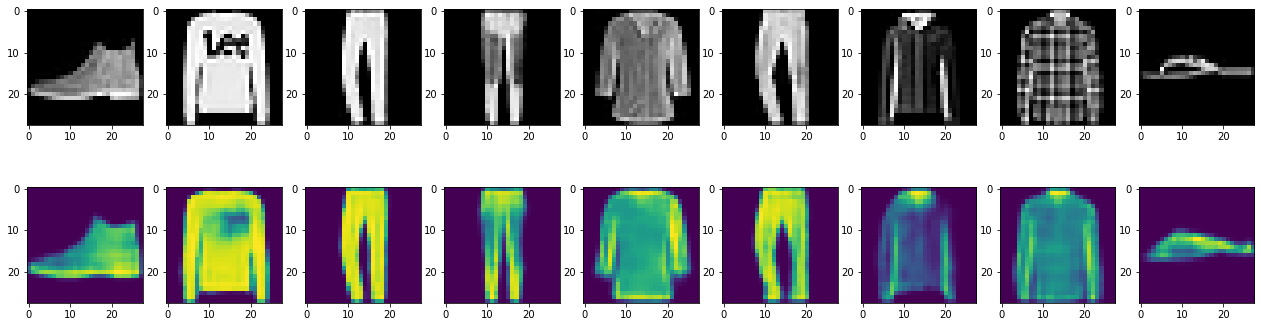

In [0]:
decoded_imgs = autoencoder.predict(x_test)

# Plot
plt.figure(figsize=(22, 6))

num_imgs = 9

for i in range(num_imgs):                        
    # display original
    ax = plt.subplot(2, num_imgs, i + 1)
    true_img = x_test[i].reshape(28, 28)
    plt.imshow(true_img, cmap='gray')

    # display reconstruction 
    ax = plt.subplot(2, num_imgs, i + 1 + num_imgs)
    reconstructed_img = decoded_imgs[i].reshape(28,28)
    plt.imshow(reconstructed_img)#, cmap='gray')

plt.show()

## **Analysis**

### Plot

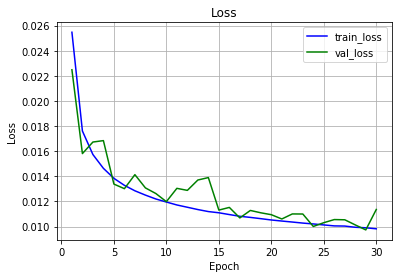

In [0]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
#plt.ylim([0,0.5])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## **실습 과제**

### 과제 1. Data set에 noise 가 추가 되는 경우 어떻게 동작하는지 확인해 보자
#### -- dataset을 읽어 오는 cell 에서 "noise_on = False" 를 "True"로 변경
#### -- Noisy data로 다시 학습하여 결과를 확인하자
#### -- dataset을 변경하고 결과를 확인하자


### 과제 2. just fitting을 위해 Batch_size와 Epoch를 최적화 해보자
#### -- 최적화 이전의 Decoded영상과 최적화 이후 영상을 비교해 보자
#### -- 최적 값은 얼마인가, 최저의 val_loss 값을 적자 :
#### -- 두개의 영상을 첨부하라 :  

